# Using pandas on the MovieLens dataset

To show pandas in a more "applied" sense, let's use it to answer some questions about the MovieLens dataset. Recall that we've already read our data into DataFrames and merged it.

In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
pd.set_option('max_columns', 50)
%matplotlib inline
engine = 'python'
warnings.simplefilter("ignore")

In [11]:
# pass in column names for each CSV
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('https://raw.githubusercontent.com/justmarkham/DAT3/master/data/u.user', sep='|', names=u_cols,
                    encoding='latin-1')

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('https://raw.githubusercontent.com/justmarkham/DAT3/master/data/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

# the movies file contains columns indicating the movie's genres
# let's only load the first five columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('https://raw.githubusercontent.com/justmarkham/DAT3/master/data/u.item', sep='|', 
                     names=m_cols, usecols=range(5), encoding='latin-1')

print(users.head())
print(ratings.head())
print(movies.head())

# create one merged DataFrame
movie_ratings = pd.merge(movies, ratings)
lens = pd.merge(movie_ratings, users)
print(movie_ratings.head())
print(lens.head())

   user_id  age sex  occupation zip_code
0        1   24   M  technician    85711
1        2   53   F       other    94043
2        3   23   M      writer    32067
3        4   24   M  technician    43537
4        5   33   F       other    15213
   user_id  movie_id  rating  unix_timestamp
0      196       242       3       881250949
1      186       302       3       891717742
2       22       377       1       878887116
3      244        51       2       880606923
4      166       346       1       886397596
   movie_id              title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            imdb_url  
0  http://us.imdb.com/M/ti

In [12]:
most_rated = lens.groupby('title').size().sort_values(ascending=False)[:25]
print(most_rated)

title
Star Wars (1977)                             583
Contact (1997)                               509
Fargo (1996)                                 508
Return of the Jedi (1983)                    507
Liar Liar (1997)                             485
English Patient, The (1996)                  481
Scream (1996)                                478
Toy Story (1995)                             452
Air Force One (1997)                         431
Independence Day (ID4) (1996)                429
Raiders of the Lost Ark (1981)               420
Godfather, The (1972)                        413
Pulp Fiction (1994)                          394
Twelve Monkeys (1995)                        392
Silence of the Lambs, The (1991)             390
Jerry Maguire (1996)                         384
Chasing Amy (1997)                           379
Rock, The (1996)                             378
Empire Strikes Back, The (1980)              367
Star Trek: First Contact (1996)              365
Back to the Fu

There's a lot going on in the code above, but it's very idomatic. We're splitting the DataFrame into groups by movie title and applying the **size** method to get the count of records in each group. Then we order our results in descending order and limit the output to the top 25 using Python's slicing syntax.

In SQL, this would be equivalent to:

SELECT title, count(1)

FROM lens

GROUP BY title

ORDER BY 2 DESC

LIMIT 25;

Alternatively, pandas has a nifty **value_counts** method - yes, this is simpler - the goal above was to show a basic **groupby** example.

In [13]:
lens.title.value_counts()[:25]

Star Wars (1977)                             583
Contact (1997)                               509
Fargo (1996)                                 508
Return of the Jedi (1983)                    507
Liar Liar (1997)                             485
English Patient, The (1996)                  481
Scream (1996)                                478
Toy Story (1995)                             452
Air Force One (1997)                         431
Independence Day (ID4) (1996)                429
Raiders of the Lost Ark (1981)               420
Godfather, The (1972)                        413
Pulp Fiction (1994)                          394
Twelve Monkeys (1995)                        392
Silence of the Lambs, The (1991)             390
Jerry Maguire (1996)                         384
Chasing Amy (1997)                           379
Rock, The (1996)                             378
Empire Strikes Back, The (1980)              367
Star Trek: First Contact (1996)              365
Back to the Future (

## Which movies are most highly rated?

In [14]:
movie_stats = lens.groupby('title').agg({'rating': [np.size, np.mean]})
movie_stats.head()

rating          
                            size      mean
title                                     
'Til There Was You (1997)      9  2.333333
1-900 (1994)                   5  2.600000
101 Dalmatians (1996)        109  2.908257
12 Angry Men (1957)          125  4.344000
187 (1997)                    41  3.024390

We can use the **agg** method to pass a dictionary specifying the columns to aggregate (as keys) and a list of functions we'd like to apply.

Let's sort the resulting DataFrame so that we can see which movies have the highest average score.

In [15]:
# sort by rating average
movie_stats.sort_values([('rating', 'mean')], ascending=False).head(10)


rating     
                                                    size mean
title                                                        
They Made Me a Criminal (1939)                         1  5.0
Marlene Dietrich: Shadow and Light (1996)              1  5.0
Saint of Fort Washington, The (1993)                   2  5.0
Someone Else's America (1995)                          1  5.0
Star Kid (1997)                                        3  5.0
Great Day in Harlem, A (1994)                          1  5.0
Aiqing wansui (1994)                                   1  5.0
Santa with Muscles (1996)                              2  5.0
Prefontaine (1997)                                     3  5.0
Entertaining Angels: The Dorothy Day Story (1996)      1  5.0

Because **movie_stats** is a DataFrame, we use the sort method - only Series objects use **order**. Additionally, because our columns are now a **MultiIndex**, we need to pass in a tuple specifying how to sort.

The above movies are rated so rarely that we can't count them as quality films. Let's only look at movies that have been rated at least 100 times.

In [16]:
atleast_100 = movie_stats['rating']['size'] >= 100
movie_stats[atleast_100].sort_values([('rating', 'mean')], ascending=False)[:15]

rating          
                                         size      mean
title                                                  
Close Shave, A (1995)                     112  4.491071
Schindler's List (1993)                   298  4.466443
Wrong Trousers, The (1993)                118  4.466102
Casablanca (1942)                         243  4.456790
Shawshank Redemption, The (1994)          283  4.445230
Rear Window (1954)                        209  4.387560
Usual Suspects, The (1995)                267  4.385768
Star Wars (1977)                          583  4.358491
12 Angry Men (1957)                       125  4.344000
Citizen Kane (1941)                       198  4.292929
To Kill a Mockingbird (1962)              219  4.292237
One Flew Over the Cuckoo's Nest (1975)    264  4.291667
Silence of the Lambs, The (1991)          390  4.289744
North by Northwest (1959)                 179  4.284916
Godfather, The (1972)                     413  4.283293

Those results look realistic. Notice that we used boolean indexing to filter our movie_stats frame.

We broke this question down into many parts, so here's the Python needed to get the 15 movies with the highest average rating, requiring that they had at least 100 ratings:

    movie_stats = lens.groupby('title').agg({'rating': [np.size, np.mean]})
    atleast_100 = movie_stats['rating'].size >= 100
    movie_stats[atleast_100].sort_values([('rating', 'mean')], ascending=False)[:15]
    
The SQL equivalent would be:

SELECT title, COUNT(1) size, AVG(rating) mean

FROM lens

GROUP BY title

HAVING COUNT(1) >= 100

ORDER BY 3 DESC

LIMIT 15;

## Limiting our population going forward

Going forward, let's only look at the 50 most rated movies. Let's make a Series of movies that meet this threshold so we can use it for filtering later.

In [18]:
most_50 = lens.groupby('movie_id').size().sort_values(ascending=False)[:50]
most_50.head(7)

movie_id
50     583
258    509
100    508
181    507
294    485
286    481
288    478
dtype: int64

The SQL to match this would be:

CREATE TABLE most_50 AS (

    SELECT movie_id, COUNT(1)
    
    FROM lens
    
    GROUP BY movie_id
    
    ORDER BY 2 DESC
    
    LIMIT 50
);

This table would then allow us to use EXISTS, IN, or JOIN whenever we wanted to filter our results. 
Here's an example using EXISTS:

SELECT *

FROM lens

WHERE EXISTS (SELECT 1 FROM most_50 WHERE lens.movie_id = most_50.movie_id);

Which movies are most controversial amongst different ages?

Let's look at how these movies are viewed across different age groups. First, let's look at how age is distributed amongst our users.

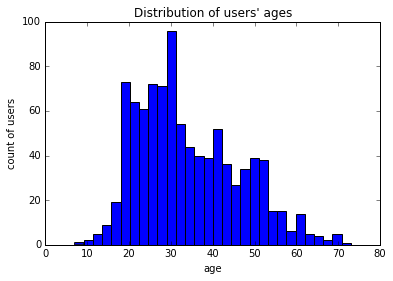

In [19]:
users.age.plot.hist(bins=30)
plt.title("Distribution of users' ages")
plt.ylabel('count of users')
plt.xlabel('age');

pandas' integration with matplotlib makes basic graphing of Series/DataFrames trivial. In this case, just call hist on the column to produce a histogram. We can also use **matplotlib.pyplot** to customize our graph a bit (always label your axes).

## Binning our users

I don't think it would be very useful to compare individual ages - let's bin our users into age groups using **pandas.cut**.

In [20]:
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
lens['age_group'] = pd.cut(lens.age, range(0, 81, 10), right=False, labels=labels)

# Signature: pd.cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False)
# Docstring:
# Return indices of half-open bins to which each value of `x` belongs.

# Parameters
# ----------
# x : array-like
#     Input array to be binned. It has to be 1-dimensional.
# bins : int or sequence of scalars
#     If `bins` is an int, it defines the number of equal-width bins in the
#     range of `x`. However, in this case, the range of `x` is extended
#     by .1% on each side to include the min or max values of `x`. If
#     `bins` is a sequence it defines the bin edges allowing for
#     non-uniform bin width. No extension of the range of `x` is done in
#     this case.
# right : bool, optional
#     Indicates whether the bins include the rightmost edge or not. If
#     right == True (the default), then the bins [1,2,3,4] indicate
#     (1,2], (2,3], (3,4].
# labels : array or boolean, default None
#     Used as labels for the resulting bins. Must be of the same length as
#     the resulting bins. If False, return only integer indicators of the
#     bins.
# retbins : bool, optional
#     Whether to return the bins or not. Can be useful if bins is given
#     as a scalar.
# precision : int
#     The precision at which to store and display the bins labels
# include_lowest : bool
#     Whether the first interval should be left-inclusive or not.

# Returns
# -------
# out : Categorical or Series or array of integers if labels is False
#     The return type (Categorical or Series) depends on the input: a Series
#     of type category if input is a Series else Categorical. Bins are
#     represented as categories when categorical data is returned.
# bins : ndarray of floats
#     Returned only if `retbins` is True.

# Notes
# -----
# The `cut` function can be useful for going from a continuous variable to
# a categorical variable. For example, `cut` could convert ages to groups
# of age ranges.

# Any NA values will be NA in the result.  Out of bounds values will be NA in
# the resulting Categorical object


# Examples
# --------
# >>> pd.cut(np.array([.2, 1.4, 2.5, 6.2, 9.7, 2.1]), 3, retbins=True)
# ([(0.191, 3.367], (0.191, 3.367], (0.191, 3.367], (3.367, 6.533],
#   (6.533, 9.7], (0.191, 3.367]]
# Categories (3, object): [(0.191, 3.367] < (3.367, 6.533] < (6.533, 9.7]],
# array([ 0.1905    ,  3.36666667,  6.53333333,  9.7       ]))
# >>> pd.cut(np.array([.2, 1.4, 2.5, 6.2, 9.7, 2.1]), 3,
#            labels=["good","medium","bad"])
# [good, good, good, medium, bad, good]
# Categories (3, object): [good < medium < bad]
# >>> pd.cut(np.ones(5), 4, labels=False)
# array([1, 1, 1, 1, 1], dtype=int64)

lens[['age', 'age_group']].drop_duplicates()[:10]

# Signature: lens.drop_duplicates(**kwargs)
# Docstring:
# Return DataFrame with duplicate rows removed, optionally only
# considering certain columns

# Parameters
# ----------
# subset : column label or sequence of labels, optional
#     Only consider certain columns for identifying duplicates, by
#     default use all of the columns
# keep : {'first', 'last', False}, default 'first'
#     - ``first`` : Drop duplicates except for the first occurrence.
#     - ``last`` : Drop duplicates except for the last occurrence.
#     - False : Drop all duplicates.
# take_last : deprecated
# inplace : boolean, default False
#     Whether to drop duplicates in place or to return a copy

# Returns
# -------
# deduplicated : DataFrame

# Remember: lens = pd.merge(movie_ratings, users)
# and
# movie_ratings = pd.merge(movies, ratings)

,age,age_group
0,60,60-69
397,21,20-29
459,33,30-39
524,30,30-39
782,23,20-29
995,29,20-29
1229,26,20-29
1664,31,30-39
1942,24,20-29
2270,32,30-39


**pandas.cut** allows you to bin numeric data. In the above lines, we first created labels to name our bins, then split our users into eight bins of ten years (0-9, 10-19, 20-29, etc.). Our use of right=False told the function that we wanted the bins to be exclusive of the max age in the bin (e.g. a 30 year old user gets the 30s label).

Now we can now compare ratings across age groups.

In [21]:
lens.groupby('age_group').agg({'rating': [np.size, np.mean]})

rating          
            size      mean
age_group                 
0-9           43  3.767442
10-19       8181  3.486126
20-29      39535  3.467333
30-39      25696  3.554444
40-49      15021  3.591772
50-59       8704  3.635800
60-69       2623  3.648875
70-79        197  3.649746

Young users seem a bit more critical than other age groups. Let's look at how the 50 most rated movies are viewed across each age group. We can use the **most_50** Series we created earlier for filtering.

In [22]:
lens.set_index('movie_id', inplace=True)

In [23]:
by_age = lens.loc[most_50.index].groupby(['title', 'age_group'])
# Recall that :
# most_50 = lens.groupby('movie_id').size().sort_values(ascending=False)[:50]
by_age.rating.mean().head(15)

title                 age_group
Air Force One (1997)  10-19        3.647059
                      20-29        3.666667
                      30-39        3.570000
                      40-49        3.555556
                      50-59        3.750000
                      60-69        3.666667
                      70-79        3.666667
Alien (1979)          10-19        4.111111
                      20-29        4.026087
                      30-39        4.103448
                      40-49        3.833333
                      50-59        4.272727
                      60-69        3.500000
                      70-79        4.000000
Aliens (1986)         10-19        4.050000
Name: rating, dtype: float64

Notice that both the title and age group are indexes here, with the average rating value being a Series. This is going to produce a really long list of values.

Wouldn't it be nice to see the data as a table? Each title as a row, each age group as a column, and the average rating in each cell.

Behold! The magic of **unstack**!

In [24]:
by_age.rating.mean().unstack(1).fillna(0)[10:20]

age_group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79
title,,,,,,,,
E.T. the Extra-Terrestrial (1982),0.0,3.680000,3.609091,3.806818,4.160000,4.368421,4.375000,0.000000
"Empire Strikes Back, The (1980)",4.0,4.642857,4.311688,4.052083,4.100000,3.909091,4.250000,5.000000
"English Patient, The (1996)",5.0,3.739130,3.571429,3.621849,3.634615,3.774648,3.904762,4.500000
Fargo (1996),0.0,3.937500,4.010471,4.230769,4.294118,4.442308,4.000000,4.333333
Forrest Gump (1994),5.0,4.047619,3.785714,3.861702,3.847826,4.000000,3.800000,0.000000
"Fugitive, The (1993)",0.0,4.320000,3.969925,3.981481,4.190476,4.240000,3.666667,0.000000
"Full Monty, The (1997)",0.0,3.421053,4.056818,3.933333,3.714286,4.146341,4.166667,3.500000
"Godfather, The (1972)",0.0,4.400000,4.345070,4.412844,3.929412,4.463415,4.125000,0.000000
Groundhog Day (1993),0.0,3.476190,3.798246,3.786667,3.851064,3.571429,3.571429,4.000000


**unstack**, well, unstacks the specified level of a **MultiIndex** (by default, **groupby** turns the grouped field into an index - since we grouped by two fields, it became a MultiIndex). We unstacked the second index (remember that Python uses 0-based indexes), and then filled in NULL values with 0.

If we would have used: **by_age.rating.mean().unstack(0).fillna(0)** We would have had our age groups as rows and movie titles as columns.

## Which movies do men and women most disagree on?
Think about how you'd have to do this in SQL for a second. You'd have to use a combination of IF/CASE statements with aggregate functions in order to pivot your dataset. Your query would look something like this:

SELECT title, AVG(IF(sex = 'F', rating, NULL)), AVG(IF(sex = 'M', rating, NULL))

FROM lens

GROUP BY title;

Imagine how annoying it would be if you had to do this on more than two columns.

DataFrame's have a **pivot_table** method that makes these kinds of operations much easier (and less verbose).

In [25]:
lens.reset_index('movie_id', inplace=True)

In [27]:
pivoted = lens.pivot_table(index=['movie_id', 'title'],
                           columns=['sex'],
                           values='rating',
                           fill_value=0)
pivoted.head(8)

,sex,F,M
movie_id,title,,
1,Toy Story (1995),3.789916,3.909910
2,GoldenEye (1995),3.368421,3.178571
3,Four Rooms (1995),2.687500,3.108108
4,Get Shorty (1995),3.400000,3.591463
5,Copycat (1995),3.772727,3.140625
6,Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),3.600000,3.571429
7,Twelve Monkeys (1995),3.560976,3.861290
8,Babe (1995),4.050000,3.974843


In [28]:
pivoted['diff'] = pivoted.M - pivoted.F
pivoted.head(8)

,sex,F,M,diff
movie_id,title,,,
1,Toy Story (1995),3.789916,3.909910,0.119994
2,GoldenEye (1995),3.368421,3.178571,-0.189850
3,Four Rooms (1995),2.687500,3.108108,0.420608
4,Get Shorty (1995),3.400000,3.591463,0.191463
5,Copycat (1995),3.772727,3.140625,-0.632102
6,Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),3.600000,3.571429,-0.028571
7,Twelve Monkeys (1995),3.560976,3.861290,0.300315
8,Babe (1995),4.050000,3.974843,-0.075157


In [29]:
pivoted.reset_index('movie_id', inplace=True)

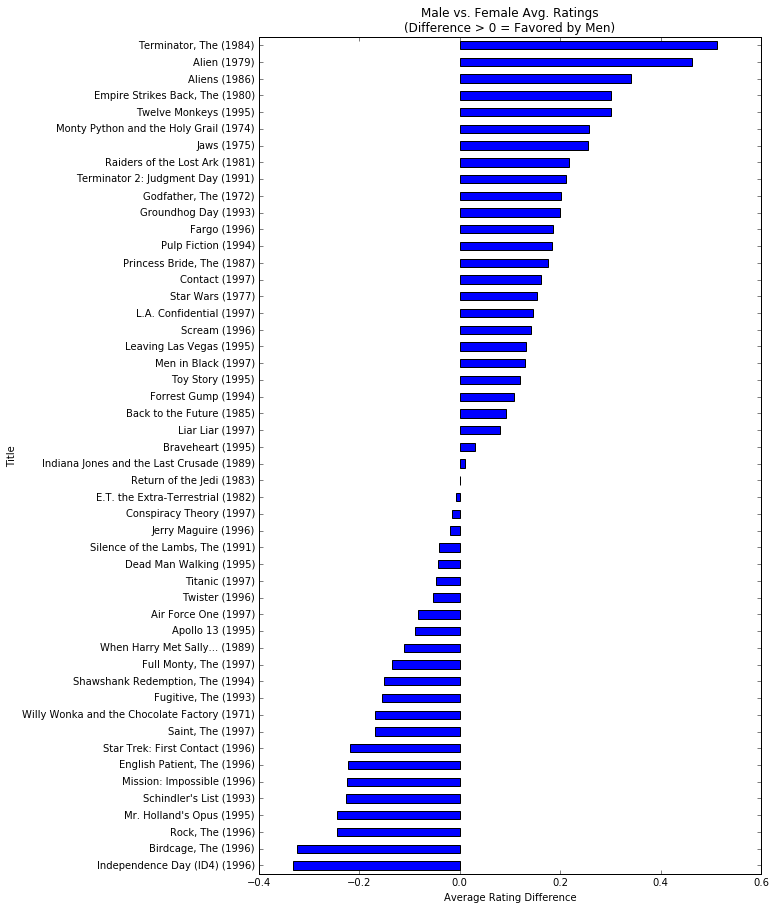

In [30]:
disagreements = pivoted[pivoted.movie_id.isin(most_50.index)]['diff']

# Signature: pivoted.movie_id.isin(values)
# Docstring:
# Return a boolean :class:`~pandas.Series` showing whether each element
# in the :class:`~pandas.Series` is exactly contained in the passed
# sequence of ``values``.

# Parameters
# ----------
# values : list-like
#     The sequence of values to test. Passing in a single string will
#     raise a ``TypeError``. Instead, turn a single string into a
#     ``list`` of one element.

# Returns
# -------
# isin : Series (bool dtype)

# Raises
# ------
# TypeError
#   * If ``values`` is a string

# See Also
# --------
# pandas.DataFrame.isin

# Examples
# --------

# >>> s = pd.Series(list('abc'))
# >>> s.isin(['a', 'c', 'e'])
# 0     True
# 1    False
# 2     True
# dtype: bool

# Passing a single string as ``s.isin('a')`` will raise an error. Use
# a list of one element instead:

# >>> s.isin(['a'])
# 0     True
# 1    False
# 2    False
# dtype: bool


disagreements.sort_values().plot(kind='barh', figsize=[9, 15])
plt.title('Male vs. Female Avg. Ratings\n(Difference > 0 = Favored by Men)')
plt.ylabel('Title')
plt.xlabel('Average Rating Difference');

Of course men like Terminator more than women. Independence Day though? Really?

Additional Resources:

* pandas documentation (http://pandas.pydata.org/pandas-docs/stable/)
* Introduction to pandas by Chris Fonnesbeck (http://nbviewer.jupyter.org/urls/gist.github.com/fonnesbeck/5850375/raw/c18cfcd9580d382cb6d14e4708aab33a0916ff3e/1.+Introduction+to+Pandas.ipynb)
* pandas videos from PyCon
* pandas and Python top 10 (http://manishamde.github.io/blog/2013/03/07/pandas-and-python-top-10/)
* pandasql (http://blog.yhat.com/posts/pandasql-sql-for-pandas-dataframes.html)
* Practical pandas by Tom Augspurger (one of the pandas developers)
* Video from Tom's pandas tutorial at PyData Seattle 2015 (https://www.youtube.com/watch?v=otCriSKVV_8)